# Using sympy: A Concrete Example of a Laplace Transform

This is a concrete example intended to illustrate the process of solving an ODE using the Laplace Transform with `sympy` and `numpy`.

The concrete problem we'll solve in this example is:

$$ m y'' + b y' + k y = f(t) $$

where $y(0) = y_0$, $y'(0) = v_0$ and $f(t) = F_0 \theta(t)$ where $\theta(t)$ is the Heaviside step function:

\begin{equation}
\theta(t) = \left\{
    \begin{array}{lr}
        0 & t < 0\\
        1 & t \geq 0
    \end{array}
    \right\}
\end{equation}

You might also know that the problem asks you to evaluate the function with specific values of the parameters:

\begin{align}
F0 &= 3\\
k & = 80\\
m & = 2\\
b & = 1\\
v0 & = 0\\
y0 & = 0
\end{align}

And then asks you to explore the behavior of the solution with varying values of the damping coefficient $b$.

Regardless of the specific values, we can easily get the Laplace Transform of this equation:

$$ m (s^2 Y(s) - s y_0 - v_0) + b(s Y(s) - y_0) + k Y(s) = \frac{F_0}{s} $$

You can do this part manually by inspection if you like. Solving for $Y(s)$ you clearly get:

$$ Y(s) = \frac{\frac{F_{0}}{s} + b y_{0} + m s y_{0} + m v_{0}}{b s + k + m s^{2}}$$

We're first going to simply use this result to get an answer in the simplest possible way with sympy only helping with the inverse laplace transform.

After that, I'll demonstrate one way to have `sympy` do some of the algebraic work for you if you prefer.

In [23]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [24]:
t = sp.symbols("t", real=True, positive=True) # you'll need symbols for s and t regardless
s = sp.symbols("s")
m,b,k,F0=sp.symbols("m,b,k,F_0", real=True, positive=True)
y0,v0=sp.symbols("y_0,v_0", real=True, positive=True)

# if you want to simply type in the Laplace Transform here you could uncomment this line:

Yt = (F0/s + b*y0 + m*s*y0 + m*v0)/(b*s + k + m*s**2)
Yt # confirm that Yt looks correct.


(F_0/s + b*y_0 + m*s*y_0 + m*v_0)/(b*s + k + m*s**2)

In [25]:
# now let's get a specific solution using the parameter values provided.

Ysp = Yt.subs({k:80, m:2, y0:0, b:1, v0:0, F0:3}) # make it concrete with fixed values
Ysp

3/(s*(2*s**2 + s + 80))

In [26]:
# now let's get the solution using the Inverse Laplace Transform:

y = sp.inverse_laplace_transform(Ysp.apart(s),s,t) # get the solution.
y

3/80 - sqrt(71)*exp(-t/4)*sin(3*sqrt(71)*t/4)/5680 - 3*exp(-t/4)*cos(3*sqrt(71)*t/4)/80

Boom! That's it. We have a solution that works for the initial conditions provided as well as the specific values of the parameters. The bad news is that we had to find `Yt` manually, and that has a substantial risk of error, especially if you're not careful!

What follows is an example of how we can represent the left hand side (LHS) and right hand side (RHS) of the equation to get the same result without as much manual work. We still need to generate the Laplace Transform of the left hand side manually, but we don't need to manage all the factors by hand.


In [27]:
Y=sp.Function("Y")


In [28]:
LHS=sp.factor(m*(s**2*Y(s) - s*y0 - v0) + b*(s*Y(s)-y0) + k*Y(s), Y(s)) # Yes this is basically a manual step
LHS # we'll explore a simpler way in the next activity!

-b*y_0 - m*s*y_0 - m*v_0 + (b*s + k + m*s**2)*Y(s)

In [29]:
f = F0*sp.Heaviside(t) # put whatever function of time you need here
f

F_0

In [30]:
RHS=sp.laplace_transform(f,t,s,noconds=True)
RHS

F_0/s

In [31]:
LHS.args # break out the pieces of the left hand side as a tuple/list of expressions.

((b*s + k + m*s**2)*Y(s), -b*y_0, -m*v_0, -m*s*y_0)

In [32]:
sp.Add(*LHS.args[1:]) # get the last three and create a term consisting of the sum of those three

-b*y_0 - m*s*y_0 - m*v_0

In [33]:
ceq = LHS.args[0]/Y(s) # get the characteristic equation. Divide out Y(s)
ceq

b*s + k + m*s**2

In [34]:
Yt = (RHS - sp.Add(*LHS.args[1:]))/ceq # manually construct the new RHS
print(Yt)
Yt

(F_0/s + b*y_0 + m*s*y_0 + m*v_0)/(b*s + k + m*s**2)


(F_0/s + b*y_0 + m*s*y_0 + m*v_0)/(b*s + k + m*s**2)

Note that `Yt` is exactly what we got manually before. If you prefer, you can just start with this by typing it in directly.

In [35]:
Ysp = Yt.subs({k:80, m:2, y0:0, b:1, v0:0, F0:3}) # make it concrete with fixed values
Ysp

3/(s*(2*s**2 + s + 80))

In [36]:
Ysp.apart(s) # sympy can also do partial fraction expansion for you...

-3*(2*s + 1)/(80*(2*s**2 + s + 80)) + 3/(80*s)

In [37]:
y = sp.inverse_laplace_transform(Ysp.apart(s),s,t) # get the solution.
y

3/80 - sqrt(71)*exp(-t/4)*sin(3*sqrt(71)*t/4)/5680 - 3*exp(-t/4)*cos(3*sqrt(71)*t/4)/80

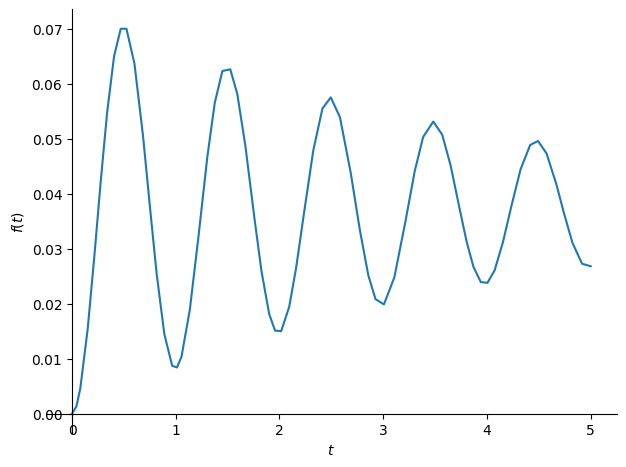

In [38]:
sp.plot(y,(t,0,5)) # we can get a crude plot in sympy

In [39]:
# but if we want total control we need numpy

yn = sp.lambdify(t,y,'numpy') # get a numpy function for y

Text(0.5, 1.0, 'solution')

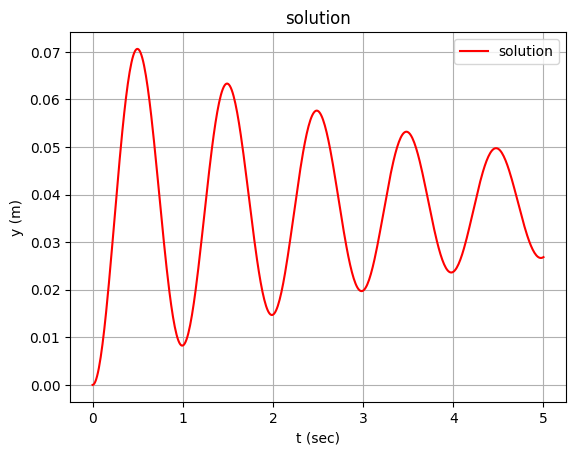

In [40]:
# now we can call this function as a numpy aware thing...

tn = np.linspace(0,5,500)
plt.plot(tn, yn(tn), 'r-', label="solution")
plt.xlabel("t (sec)")
plt.ylabel("y (m)")
plt.grid()
plt.legend()
plt.title("solution")

What if we want to experiment with damping? We can leave the damping parameter as a symbol:

In [41]:
Ysp_b = Yt.subs({k:80, m:2, y0:0, v0:0, F0:3}) # make it concrete with fixed values
Ysp_b

3/(s*(b*s + 2*s**2 + 80))

In [42]:
# then take the inverse transform with b as a paramter
yb = sp.inverse_laplace_transform(Ysp_b.apart(s),s,t) # get the solution.
yb

-3*b*exp(-b*t/4)*sin(t*sqrt(640 - b**2)/4)/(80*sqrt(640 - b**2)) + 3/80 - 3*exp(-b*t/4)*cos(t*sqrt(640 - b**2)/4)/80

Yikes! That's super complicated, but no matter, we're letting `sympy` do the work anyway. 😂

How could we display results for a range of b values?

In [43]:
sample_bs = [2,4,8,10,16,32] # a range of b values

ynbs = [sp.lambdify(t, yb.subs({b:bv})) for bv in sample_bs]
ynbs

[<function _lambdifygenerated(t)>,
 <function _lambdifygenerated(t)>,
 <function _lambdifygenerated(t)>,
 <function _lambdifygenerated(t)>,
 <function _lambdifygenerated(t)>,
 <function _lambdifygenerated(t)>]

Text(0.5, 1.0, 'solutions')

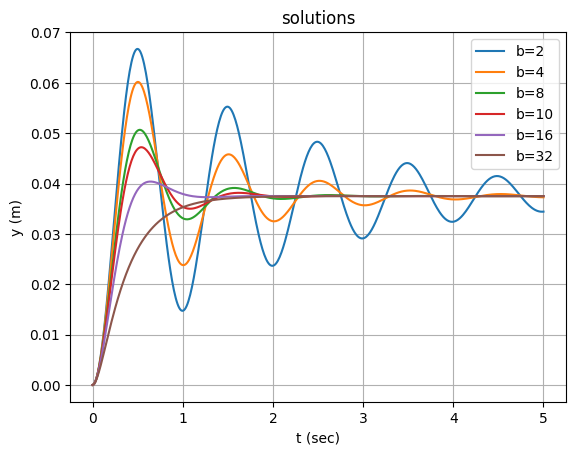

In [44]:
# now we can call these functions a numpy aware things ...

tn = np.linspace(0,5,500)
for i in range(len(sample_bs)):
  plt.plot(tn, ynbs[i](tn), label=f"b={sample_bs[i]}")

plt.xlabel("t (sec)")
plt.ylabel("y (m)")
plt.grid()
plt.legend()
plt.title("solutions")